In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(device)

from hydra.utils import instantiate
from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.8.1+cu102
cuda:0


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [47]:
with initialize(config_path='./scripts/'):
    cfg = compose("one_source")

print('config: ')
print(cfg)

config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [686.0], 'n_batches': 10, 'batch_size': 20, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 1, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'psf_params_file': '/home/runingli/astronomy/bliss/data/sdss/2583/2/136/psField-002583-2-0136.fits', 'sdss_bands': [2]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 8, 'max_detections': 1, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.I

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [48]:
cfg.datasets.simulated_m2.update({'generate_device': 'cuda:0'})

# Define models

In [49]:
model_filename = './fits/starnet-onesource'

dataset = instantiate(cfg.training.dataset)

sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [50]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [51]:
from bliss.datasets import simulated 
cfg.datasets.simulated_m2.update({'batch_size': 1})
dataset = instantiate(cfg.training.dataset)

batch =  dataset.get_batch()

In [52]:
batch['images'].shape

torch.Size([1, 1, 106, 106])

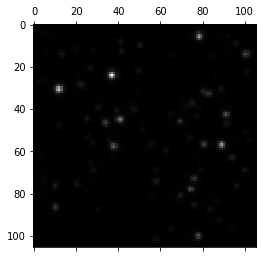

In [53]:
plt.matshow(batch['images'][0, 0].cpu(), 
            cmap=plt.cm.get_cmap("gray"))

In [54]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [55]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

# Check out uncertainties 

In [56]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [57]:
def sample_encoder(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_samples = image_encoder.sample(var_params, 5000)

    return tile_samples

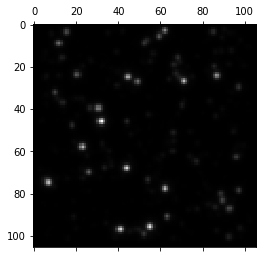

In [58]:
batch =  dataset.get_batch()

plt.matshow(batch['images'][0, 0].cpu(), 
            cmap=plt.cm.get_cmap("gray"))

In [59]:
map_estimate = get_map_estimate(sleep_net.image_encoder, 
                                batch['images'],
                                dataset.background.view(1, 1, 1, 1).to(device), 
                                slen = 100)

In [60]:
tile_samples = sample_encoder(sleep_net.image_encoder, 
                              batch['images'],
                              dataset.background.view(1, 1, 1, 1).to(device), 
                              slen = 100)

In [61]:
tile_samples['n_sources'].shape

torch.Size([5000, 1, 50, 50])

In [62]:
starnet_nsources = tile_samples['n_sources'].sum(-1).sum(-1).sum(-1).detach().cpu().numpy()

In [63]:
starnet_nsources

array([606, 624, 625, ..., 615, 603, 610])

In [64]:
starnet_nsources.mean()

615.5058

In [65]:
map_estimate['n_sources']

tensor([543], device='cuda:0')

In [66]:
batch['n_sources'].sum()

tensor(579, device='cuda:0')

In [67]:
np.quantile(starnet_nsources, q = [0.05, 0.95])

array([597., 634.])

In [69]:
n_trials = 1000
is_covered = np.zeros(n_trials)

for i in range(n_trials):
    if(i % 100 == 0): 
        print(i)
        
    batch =  dataset.get_batch()
    tile_samples = sample_encoder(sleep_net.image_encoder, 
                                  batch['images'],
                                  dataset.background.view(1, 1, 1, 1).to(device), 
                                  slen = 100)
    
    starnet_nsources = tile_samples['n_sources'].sum(-1).sum(-1).sum(-1).detach().cpu().numpy()
    conf_interval = np.quantile(starnet_nsources, 
                                q = [0.05, 0.95])
    
    is_covered[i] = (batch['n_sources'].sum() > conf_interval[0]) & \
                    (batch['n_sources'].sum() < conf_interval[1])

0
100
200
300
400
500
600
700
800
900


In [70]:
np.mean(is_covered)

0.002